# Getting Started

## Preparing a radiative transfer object

After installation has finished, let's try to calculate a first spectrum!
You can simply load petitRADTRANS by typing:

In [1]:
import numpy as np
from petitRADTRANS import Radtrans

An instance of a radiative transfer object can then be created like this (the ``_HITEMP`` and ``_allard`` identifiers stand for different line lists, or line broadening treatments, see ["Available opacity species"](../available_opacities.html)):

In [2]:
atmosphere = Radtrans(line_species = ['H2O_HITEMP', 
                                      'CO_all_iso_HITEMP', 
                                      'CH4', 
                                      'CO2', 
                                      'Na_allard',
                                      'K_allard'],
                      rayleigh_species = ['H2', 'He'],
                      continuum_opacities = ['H2-H2', 'H2-He'],
                      wlen_bords_micron = [0.3, 15])

  Read line opacities of CH4...
 Done.
  Read line opacities of CO2...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
 Done.



This will create an object ready to calculate spectra once the atmospheric parameters (temperature, abundances, mean molecular weight etc.) are set. Here we asked for the following molecular or atomic line absorbers to be inlcuded: $\rm H_2O$, $\rm CO$,  $\rm CH_4$, $\rm CO_2$, $\rm Na$, and $\rm K$. Additionally, the Rayleigh scattering cross-sections for $\rm H_2$ and $\rm He$ were loaded, as well as the collision induced absorption (CIA) cross-sections for the $\rm H_2$-$\rm H_2$ and $\rm H_2$-$\rm He$ pairs. The wavelength range that was loaded for the opacities here extends from 0.3 to 15 microns.

Now, let's define the pressures of the atmospheric layers.
Note that the pressures **must** always be sorted in increasing order, and be equidistant in log-space. The pressure is in units of **bar**, although all other units in *petitRADTRANS* are in cgs. Typically include of the order of 100 layers in your computations:

In [3]:
pressures = np.logspace(-6, 2, 100)

<div class="alert alert-warning">

**Units in petitRADTRANS:** all units in *petitRADTRANS* are in cgs, **except for pressure**, which is in bars, **and the mean molecular weight (MMW)**, which is in units of atomic mass units.
</div>

In [4]:
atmosphere.setup_opa_structure(pressures)

And we are done! These steps only need to be carried out once, after this we are free to play with this radiative transfer object, for example change the temperature, abundances, etc. Only if additional opacity species need to be loaded is it necessary to create a new Radtrans instance.

## Calculating a transmission spectrum

Let's calculate a first spectrum for a hot Jupiter, first in transmission. Let's assume an isothermal temperature profile, for now. We start by specifing the temperature array, and abundance dictionery, containing the mass fractions of the atmospheric material, at every layer, and the atmospheric mean molecular weight, at every layer, in units of amu:

In [5]:
temperature = 1200. * np.ones_like(pressures)

mass_fractions = {}
mass_fractions['H2'] = 0.74 * np.ones_like(temperature)
mass_fractions['He'] = 0.24 * np.ones_like(temperature)
mass_fractions['H2O_HITEMP'] = 0.001 * np.ones_like(temperature)
mass_fractions['CO_all_iso_HITEMP'] = 0.01 * np.ones_like(temperature)
mass_fractions['CO2'] = 0.00001 * np.ones_like(temperature)
mass_fractions['CH4'] = 0.000001 * np.ones_like(temperature)
mass_fractions['Na_allard'] = 0.00001 * np.ones_like(temperature)
mass_fractions['K_allard'] = 0.000001 * np.ones_like(temperature)

MMW = 2.33 * np.ones_like(temperature)

**Note that these are freely made up values, however. The P-T profile of a real planet may well be different, and not isothermal. Also the abundances are just made up for this simple example here** (see ["Interpolating chemical equilibrium abundances"](poor_man.html) for how to improve this.)

<div class="alert alert-warning">

**Abundances in petitRADTRANS:** abundances in pRT are in units of **mass fractions**, not number fractions (aka volume mixing ratio, VMR). You can convert between mass fractions and VMRs by using
\begin{equation}
X_i = \frac{\mu_i}{\mu}n_i,
\end{equation}
where $X_i$ is the mass fraction of species $i$, $\mu_i$ the mass of a single molecule/atom/ion/... of species $i$, $\mu$ is the atmospheric mean molecular weight, and $n_i$ is the VMR of species $i$.

</div>

Next, let's assume a planetary radius and gravity at a given pressure $P_0=0.01$ bar in the atmosphere, and we are all set!

In [6]:
from petitRADTRANS import nat_cst as nc
R_pl = 1.838*nc.r_jup_mean
gravity = 1e1**2.45
P0 = 0.01

Now we simply generate a transmission spectrum by typing:

In [7]:
atmosphere.calc_transm(temperature, mass_fractions, gravity, MMW, R_pl=R_pl, P0_bar=P0)

Let's plot the transit radius!

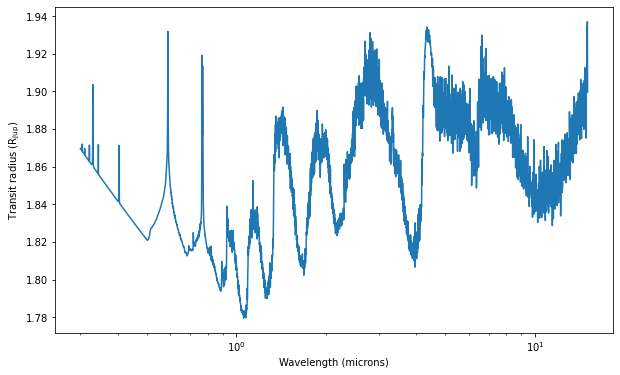

<Figure size 720x432 with 0 Axes>

In [8]:
import pylab as plt
plt.rcParams['figure.figsize'] = (10, 6)

plt.plot(nc.c/atmosphere.freq/1e-4, atmosphere.transm_rad/nc.r_jup_mean)

plt.xscale('log')
plt.xlabel('Wavelength (microns)')
plt.ylabel(r'Transit radius ($\rm R_{Jup}$)')
plt.show()
plt.clf()

## Calculating an emission spectrum

<div class="alert alert-warning">

**Scattering and petitRADTRANS:** scattering is included for emission spectra in petitRADTRANS only if requested specifically when generating the Radtrans object, as it increases the runtime (see ["Scattering for Emission Spectra"](emis_scat.html) for an example how to do this). We neglect the scattering here.

</div>

Let's calculate an emission spectrum. Using an isothermal temperature structure as above would simply result in a black body spectrum:

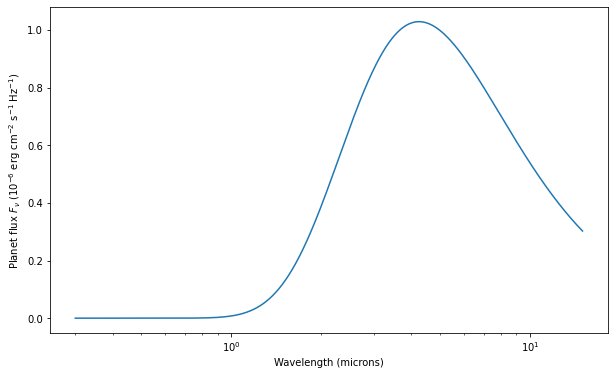

<Figure size 720x432 with 0 Axes>

In [9]:
atmosphere.calc_flux(temperature, mass_fractions, gravity, MMW)

plt.plot(nc.c/atmosphere.freq/1e-4, atmosphere.flux/1e-6)

plt.xscale('log')
plt.xlabel('Wavelength (microns)')
plt.ylabel(r'Planet flux $F_\nu$ (10$^{-6}$ erg cm$^{-2}$ s$^{-1}$ Hz$^{-1}$)')
plt.show()
plt.clf()

So let's try something different instead, namely the often-used analytical atmospheric P-T profile from [Guillot (2010)](http://adsabs.harvard.edu/abs/2010A%26A...520A..27G), his Equation 29:

\begin{equation}
T^4 = \frac{3T_{\rm int}^4}{4}\left(\frac{2}{3}+\tau\right) + \frac{3T_{\rm equ}^4}{4}\left[\frac{2}{3}+\frac{1}{\gamma\sqrt{3}}+\left(\frac{\gamma}{\sqrt{3}}-\frac{1}{\gamma\sqrt{3}}\right)e^{-\gamma\tau\sqrt{3}}\right]
\end{equation}

with $\tau = P\kappa_{\rm IR}/g$. Here, $\tau$ is the optical depth, $P$ the pressure, $\kappa_{\rm IR}$ is the atmospheric opacity in the IR wavelengths (i.e. the cross-section per unit mass), $\gamma$ is the ratio between the optical and IR opacity, $T_{\rm equ}$ the atmospheric equilibrium temperature, and $T_{\rm int}$ is the planetary internal temperature.

In [10]:
kappa_IR = 0.01
gamma = 0.4
T_int = 200.
T_equ = 1500.

temperature = nc.guillot_global(pressures, kappa_IR, gamma, gravity, T_int, T_equ)

Let's plot the P-T profile:

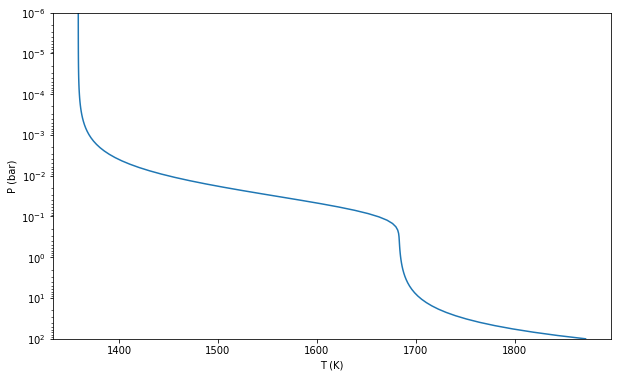

<Figure size 720x432 with 0 Axes>

In [11]:
plt.plot(temperature, pressures)
plt.yscale('log')
plt.ylim([1e2, 1e-6])
plt.xlabel('T (K)')
plt.ylabel('P (bar)')
plt.show()
plt.clf()

An recalculate the spectrum:

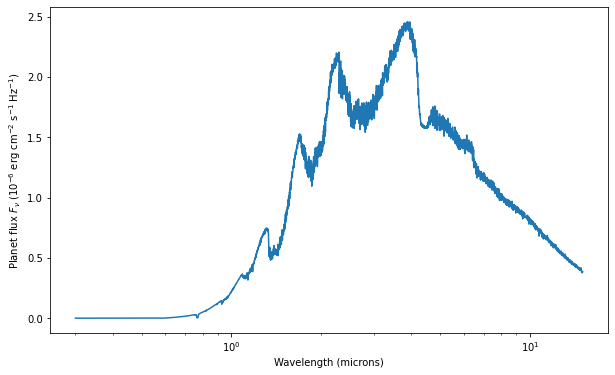

<Figure size 720x432 with 0 Axes>

In [12]:
atmosphere.calc_flux(temperature, mass_fractions, gravity, MMW)

plt.plot(nc.c/atmosphere.freq/1e-4, atmosphere.flux/1e-6)

plt.xscale('log')
plt.xlabel('Wavelength (microns)')
plt.ylabel(r'Planet flux $F_\nu$ (10$^{-6}$ erg cm$^{-2}$ s$^{-1}$ Hz$^{-1}$)')
plt.show()
plt.clf()